In [61]:
import calendar
import logging
import os
from pathlib import Path

import numpyro
import pandas as pd
import torch
import xarray as xr
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    geom_point,
    facet_wrap,
    guides,
    ggplot,
    facet_grid,
    scale_x_datetime,
    geom_ribbon,
    theme,
    theme_bw,
    ylab,
    element_text,
    scale_color_brewer,
    geom_hline,
    geom_smooth,
    xlab,
    geom_boxplot,
    scale_x_continuous,
    element_blank,
    guide_legend
)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import kernels
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.data_loading.data_loading import load_data
from src.modeling.ensemble import DefaultEnsemble, BoostedRegressor, RandomForest
from src.modeling.gaussian_process import SklearnGPModel, MultitaskGP
from src.modeling.lm import LinearModel
from src.modeling.metrics import summarize
from src.modeling.var_models import VAR, NARX
from src.preprocessing.preprocessing import XArrayStandardScaler, SeasonalFeatures, XArrayFeatureUnion
from src.utils import flatten_array

logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
torch.set_default_device(device)

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

pd.options.display.float_format = "{:,.3f}".format


In [ ]:
def rename_lakes(x):
    return {"eri": "Erie", "sup": "Superior", "mic_hur": "Michigan/Huron", "ont": "Ontario"}.get(x, x)


lake_data = (load_data(["rnbs", "precip", "temp", "evap"]).
             sel(type="Basin").
             dropna("Date").
             to_array().
             transpose("Date", "lake", ...)
             )
lake_data

In [ ]:
num_splits = 5
forecast_steps = 13

test_data = lake_data.sel(Date=slice("2006", "2010"))
train_data = lake_data.sel(Date=slice(None, "2005"))

splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps, gap=0)
splits = list(splitter.split(train_data))

X, y = train_data.sel(variable=["precip", "temp", "evap"]).drop("type"), train_data.sel(
    variable=["rnbs"]).squeeze().drop(
    ["type", "variable"])
test_x, test_y = test_data.sel(variable=["precip", "temp", "evap"]).drop("type"), test_data.sel(
    variable=["rnbs"]).squeeze().drop(
    ["type", "variable"])

y_scaler = XArrayStandardScaler()
y = y_scaler.fit_transform(y)
test_y = y_scaler.transform(test_y)
for train, test in splits:
    # print(X.indexes["Date"][train], X.indexes["Date"][test])
    print(len(train), X.indexes["Date"][test])


In [ ]:
plot_data = lake_data.sel(variable="rnbs").drop(["variable", "type"]).to_dataframe(name="rnbs").reset_index()

(
        ggplot(data=plot_data, mapping=aes(x="Date", y="rnbs")) +
        geom_line() +
        facet_wrap("~lake", labeller=rename_lakes) +
        theme_bw() +
        theme(axis_title_x=element_blank(), figure_size=(8, 4)) +
        scale_x_datetime(labels=date_format(fmt="%Y")) +
        ylab("RNBS")
)

In [ ]:
preprocessor = XArrayFeatureUnion([
    ("preprocess", Pipeline(steps=[
        ("scale", XArrayStandardScaler()),
        ("flatten", FunctionTransformer(flatten_array))
    ])),
    ("seasonal", SeasonalFeatures())
])

gp_models = {
    "GP_Matern": Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", SklearnGPModel(
                                     1.0 * kernels.Matern(
                                         nu=1.5) * kernels.RationalQuadratic()
                                 ))
                                 ]),
    "MultitaskGP": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", MultitaskGP(epochs=100, rank=1))
    ]),
}

simple_models = {
    "SimpleLM": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", LinearModel())
    ]),
    "RF": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForest())
    ]),
    "BoostedTrees": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", BoostedRegressor(n_estimators=500, learning_rate=0.1))
    ]),
}

varx_models = {
    "NARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            NARX(lags={"y": 3, "temp": 0, "precip": 0, "evap": 0}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            VAR(lags={"y": 3, "precip": 0, "temp": 0, "evap": 0}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),

}

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    **simple_models,
    **gp_models,
    **varx_models,
}



In [ ]:

# train_x = preprocessor.fit_transform(X)
# 
# cv = GridSearchCV(estimator=GradientBoostingRegressor(alpha=0.50, loss="quantile"),
#                   param_grid={"n_estimators": [500, 1000, 1500, 2000], "learning_rate": [0.01, 0.1, 0.25, 0.5]},
#                   cv=TimeSeriesSplit(), n_jobs=-1)
# train_x, train_y = xr.align(train_x, y)
# cv.fit(train_x, train_y[:, 1])
# cv.best_params_


In [ ]:
# run cross validation
results = []
overwrite = False
results_dir = Path("./results")
all_models_dir = Path("./models")
results_dir.mkdir(exist_ok=True)
all_models_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    model_dir = all_models_dir / name
    model_dir.mkdir(exist_ok=True)
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        prediction_file = (results_dir / f"{name}_{i}.csv")
        if prediction_file.exists() and not overwrite:
            logging.info(f"Loading {name} model (split {i + 1}/{num_splits})")
            predictions = pd.read_csv(prediction_file).assign(split=i + 1)
            predictions["Date"] = pd.to_datetime(predictions["Date"])
        else:
            logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
            model.fit(X[train_id], y[train_id])
            preds = model.predict(X[:max(test_id) + 1], y=y[:max(test_id) + 1], forecast_steps=forecast_steps)

            array = xr.concat([
                preds,
                y[test_id].expand_dims({"value": ["true"]}, axis=-1)
            ], dim="value")

            predictions = pd.concat([
                arr.to_pandas().assign(months_ahead=list(range(1, forecast_steps + 1)), model=name)
                for arr in array.transpose("lake", ...)
            ], axis=0, keys=preds.lake.values, names=["lake"]).assign(split=i + 1)
            predictions.to_csv(prediction_file)
        results.append(predictions)

cv_results = pd.concat(results, axis=0)
cv_results.head()

In [ ]:
cv_results_12 = cv_results[cv_results["months_ahead"] <= 12].reset_index()
cv_results_12.groupby(["lake", "model"]).apply(summarize, include_groups=False)

In [ ]:
cv_results_12.groupby(["model"]).apply(summarize, include_groups=False)

In [ ]:
cv_results_12[cv_results_12["months_ahead"].isin([1, 3, 6, 12])].groupby(["months_ahead", "model"]).apply(summarize,
                                                                                                          include_groups=False)

In [ ]:
# import warnings
# 
# warnings.filterwarnings("ignore")
# 
# plot_data = cv_results_12[cv_results_12["split"] <= 6].reset_index()
# 
# (
#         ggplot(data=plot_data.reset_index(), mapping=aes(x="Date", y="mean", group="split"))
#         + geom_line(data=y.to_dataframe(name="rnbs").reset_index(), mapping=aes(x="Date", y="rnbs"), color="black",
#                     inherit_aes=False)
#         + geom_line(color="red")
#         + facet_grid("model~lake", labeller=rename_lakes)
#         + scale_x_datetime(
#     limits=[plot_data.Date.min(), plot_data.Date.max()],
#     labels=date_format(fmt="%Y"), breaks=date_breaks("1 year"))
#         + geom_ribbon(
#     mapping=aes(x="Date", ymin="lower", ymax="upper"), alpha=0.3, fill="red"
# ) + ylab("RNBS (standardized)")
#         + theme_bw()
#         + theme(text=element_text(size=12), figure_size=(12, 12))
# )


In [ ]:
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month, cv_results_12["Date"].dt.month_name()]).apply(
    summarize)

In [ ]:
cv_results_12.groupby(["months_ahead", cv_results_12["model"]]).apply(summarize)
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month_name(), cv_results_12["model"]]).apply(
    summarize)


In [ ]:
grp_data = cv_results_12
grp_data.groupby(["months_ahead", "model"]).apply(summarize)[["rmse", "coverage", "crps", "r2"]]

In [ ]:
# lake_data.sel(Date=slice(None, test_data.indexes["Date"].min()))
import numpy as np

steps_ahead = xr.DataArray(np.arange(1, 13), dims=["steps_ahead"], coords={"steps_ahead": np.arange(1, 13)})

pred_set = []
test_results_dir = Path("./test_results")
test_results_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    logging.info(f"----------Running preds for model {name}----------")
    for i in range(test_data.shape[0]):
        try:
            preds = pd.read_csv(test_results_dir / f"{name}_{i}.csv")
            preds["Date"] = pd.to_datetime(preds["Date"])
        except FileNotFoundError:

            logging.info(f"Step {i}")
            add_step = min(test_data.shape[0] - i, 12)
            pred_x, pred_y = xr.concat([X, test_x[:(i + add_step)]], "Date"), xr.concat([y, test_y[:i + add_step]],
                                                                                        "Date")
            preds = all_models[name].predict(X=pred_x,
                                             y=pred_y,
                                             forecast_steps=add_step)
            steps_ahead = pd.Series(np.arange(1, add_step + 1), index=preds.indexes["Date"])
            preds = preds.to_dataframe(dim_order=["Date", "lake", "value"]).reset_index(["lake", "value"]).assign(
                model=name)
            preds["steps_ahead"] = steps_ahead
            preds.to_csv(test_results_dir / f"{name}_{i}.csv")
        pred_set.append(preds.reset_index())

In [ ]:

all_preds = pd.concat(pred_set)
all_preds = all_preds.pivot(index=["Date", "lake", "model", "steps_ahead"], columns="value",
                            values="forecasts").reset_index()

test_preds = all_preds.merge(test_y.to_dataframe(name="true").reset_index())

test_preds.head()


In [ ]:
rmse_df = test_preds.groupby([test_preds.Date.dt.month, "model", "lake", "steps_ahead"]).apply(
    summarize).reset_index()

ggplot(data=rmse_df, mapping=aes(x="Date", y="rmse", group="Date")) + geom_boxplot() + scale_x_continuous(
    breaks=np.arange(1, 13), labels=calendar.month_abbr[1:]) + theme_bw() + ylab("RMSE") + theme(
    axis_title_x=element_blank(), figure_size=(12, 5))


In [ ]:
melted_data = test_preds.set_index(["Date", "lake", "model", "steps_ahead"]).melt(ignore_index=False)
transformed_data = [
    y_scaler.inverse_transform(
        df.reset_index().pivot(index=["Date", "model", "steps_ahead"], columns="lake", values="value")[
            ["sup", "mic_hur", "eri", "ont"]]).melt(
        ignore_index=False, value_name=grp[-1]).set_index("lake", append=True)
    for grp, df in melted_data.groupby(["variable"])
]

transformed_vals = pd.concat(transformed_data, axis=1).reset_index()

In [ ]:
plot_data = test_preds[
    (test_preds["model"] == "NARX") & test_preds["steps_ahead"].isin([1, 3, 6, 12])]

(

        ggplot(data=plot_data, mapping=aes(x="Date", y="true")) +
        facet_grid("lake~steps_ahead", labeller=rename_lakes) +
        geom_line() +
        geom_line(mapping=aes(y="mean"), color="red") +
        theme_bw() +
        geom_ribbon(aes(ymin="lower", ymax="upper", y="mean"), fill="red", alpha=0.3) +
        scale_x_datetime(
            limits=[plot_data.Date.min(), plot_data.Date.max()],
            labels=date_format(fmt="%Y"), breaks=date_breaks("1 year")
        ) +
        theme(axis_text_x=element_text(angle=45), axis_title_x=element_blank()) +
        ylab("RNBS (standardized)")

)

In [ ]:
plot_data = test_preds.groupby(["model", "steps_ahead"]).apply(summarize).reset_index()
plot_data = plot_data[plot_data["model"].isin(["VARX", "NARX"])]

(
        ggplot(data=plot_data, mapping=aes(x="steps_ahead", y="interval_len", linetype="model"))
        + geom_line()
        + theme_bw()
        + geom_point(shape="x")
        + theme(legend_position="top", legend_title=element_blank(), figure_size=(5, 2.5), text=element_text(size=7))
        + scale_color_brewer(palette="Dark2",
                             type="qual",
                             name="Model")
        + scale_x_continuous(breaks=np.arange(1, 13))
        + ylab("Interval Length")
        + xlab("Months Ahead")
)

In [ ]:
scatter_data = transformed_vals.groupby(["model", "lake"]).apply(summarize).reset_index()
scatter_data["method_type"] = np.where(scatter_data["model"].isin(["VARX", "NARX"]), "AR", "Non-AR")
(
        ggplot(data=scatter_data, mapping=aes(x="interval_len", y="coverage")) +
        geom_hline(yintercept=0.95, linetype='--') +
        geom_point() +
        geom_smooth(method="lm", se=False) +
        facet_wrap("~lake", nrow=2, labeller=rename_lakes) +
        theme_bw() +
        theme(legend_position="right", legend_title=element_blank()) +
        scale_color_brewer(palette="Dark2", type="qual", name="Method Type") +
        ylab("Coverage") +
        xlab("Interval Length")
)


In [ ]:
from IPython.display import display_markdown

agg_values = ["coverage", "interval_len"]
lake_table = test_preds.groupby(["model", "lake"]).apply(summarize)[agg_values]

model_display_names = {
    "BoostedTrees": "Boosted Trees",
    "SimpleLM": "Linear Model",
    "Default": "Default Ensemble",
    "GP_Matern": "Gaussian Process",
    "MultitaskGP": "Multitask GP",
    "NARX": "NARX",
    "VARX": "VARX",
    "RF": "Random Forest"
}
lake_table.index = pd.MultiIndex.from_tuples(
    [(model_display_names[model], rename_lakes(lake)) for model, lake in lake_table.index], names=["model", "lake"])

lake_table = lake_table.melt(ignore_index=False).reset_index().pivot_table(index=["model", "variable"],
                                                                           columns=["lake"],
                                                                           values="value")

full_table = test_preds.groupby("model").apply(summarize)[agg_values]
full_table.index = pd.Index([model_display_names[model] for model in full_table.index], name="model")

full_table = full_table.melt(ignore_index=False).reset_index().assign(lake="All").pivot_table(
    index=["model", "variable"],
    columns=["lake"],
    values="value")
merged_table = lake_table.merge(full_table, left_index=True, right_index=True)

print(merged_table.melt(ignore_index=False).reset_index().pivot(index=["model"], columns=["lake", "variable"],
                                                                values="value").to_latex(float_format="%0.3f"))


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


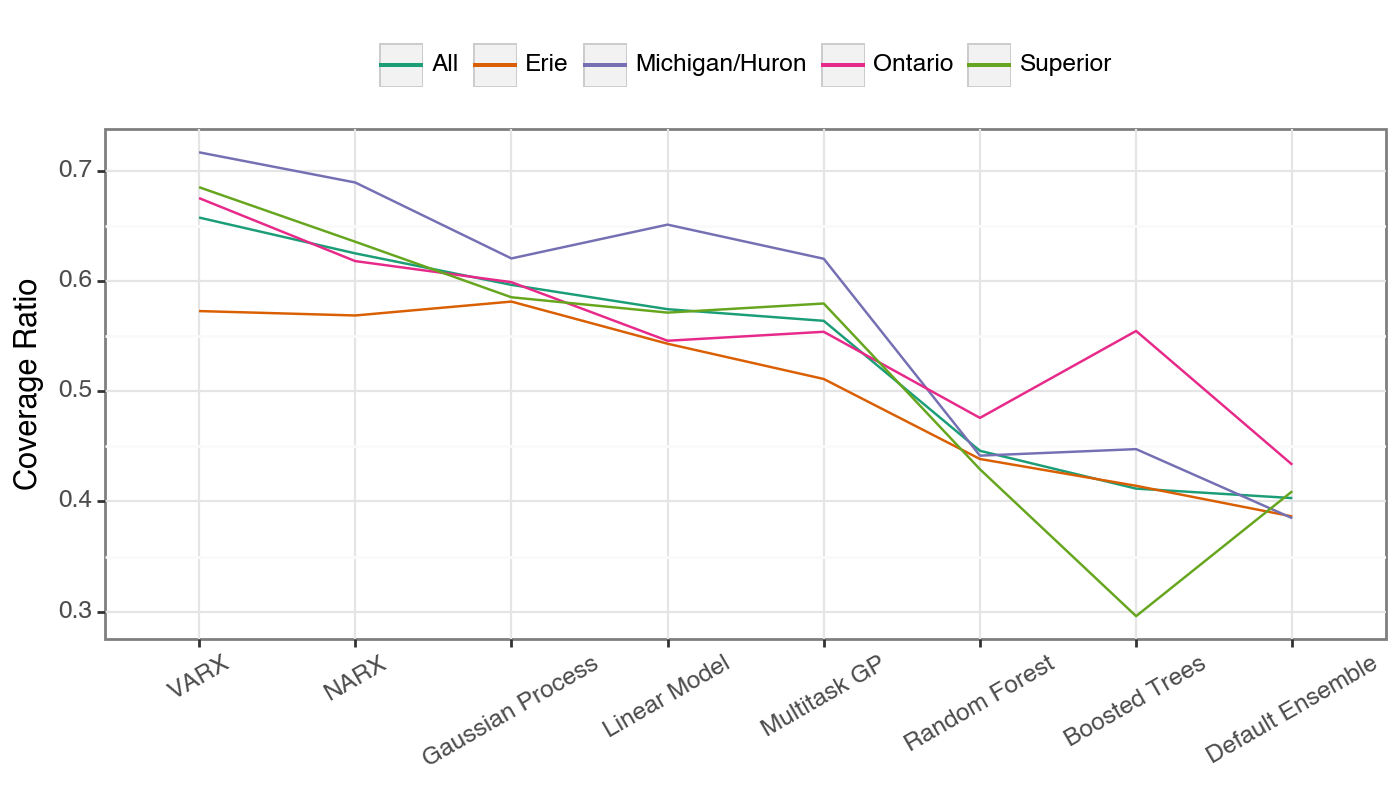

<Figure Size: (700 x 400)>

In [86]:
ratios = merged_table.melt(ignore_index=False).reset_index().pivot(columns=["variable"], index=["model", "lake"],
                                                                   values="value")
ratios["coverage_ratio"] = ratios["coverage"] / ratios["interval_len"]
plot_data = ratios.sort_values(["lake", "model"], ascending=False).reset_index()

(
        ggplot(data=plot_data,
               mapping=aes(x="reorder(model, -coverage_ratio)", y="coverage_ratio", group="lake",
                           color="lake"))
        + geom_line()
        + scale_color_brewer(palette="Dark2", type="qual")
        + theme_bw()
        + theme(axis_text_x=element_text(angle=30), axis_title_x=element_blank(), figure_size=(7, 4.0),
                legend_position="top", legend_title=element_blank())
        + ylab("Coverage Ratio")
    # + guides(color=guide_legend(title=element_blank()))
)

